In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from datetime import datetime
import scipy.io as sio
import datetime
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import pickle
import matplotlib.dates as mdates


import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, moca, gaussian_vel_reconstruction, espra


In [2]:
def smooth(x, y, num=1000, window=50):
    from scipy.interpolate import interp1d
    from scipy.ndimage import uniform_filter1d
    x = np.asarray(x); y = np.asarray(y)
    # Step 1: interpolate to uniform y
    y_uniform = np.linspace(y.min(), y.max(), num)
    f_interp = interp1d(y, x, kind='linear', fill_value='extrapolate')
    x_uniform = f_interp(y_uniform)
    # Step 2: smooth x on the uniform y grid
    x_smooth_uniform = uniform_filter1d(x_uniform, size=window)
    # Step 3: interpolate back to original y
    f_smooth = interp1d(y_uniform, x_smooth_uniform, kind='linear', fill_value='extrapolate')
    x_smooth = f_smooth(y)

    return x_smooth
    

#### Drifter Data

In [3]:
drifter_path = '/srv/scratch/z5297792/IN2023/2023_drifters.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
tim_drif, ID_drif = drifter_dataset['time'][:].data, drifter_dataset['ID'][:].data
dt_strings = [b''.join(row).decode('utf-8') for row in tim_drif]
tim_drif = [datetime.fromisoformat(s) for s in dt_strings]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters = df_drifters.loc[df_drifters['ID'].isin([12, 13, 16])]
df_drifters = df_drifters.reset_index().drop(columns=['index'])

df_drifters['Time'] = pd.to_datetime(df_drifters['Time'])
df_drifters = df_drifters.set_index('Time').sort_index()

df_drifters_6hr = pd.DataFrame()

for d in df_drifters['ID'].unique():
    df = df_drifters[df_drifters['ID'] == d]

    df_drifter_6hr = df.resample('6h').mean().dropna().reset_index()
    df_drifter_6hr['ID'] = d  # preserve ID

    df_drifters_6hr = pd.concat([df_drifters_6hr, df_drifter_6hr], ignore_index=True)


In [4]:
df_drifters_6hr 

,Time,ID,Lon,Lat,u,v
0,2023-10-22 00:00:00,12,154.196499,-38.023406,-0.455387,-0.194328
1,2023-10-22 06:00:00,12,154.147181,-38.024623,-0.234342,0.144565
2,2023-10-22 12:00:00,12,154.069702,-37.973901,-0.311799,0.256104
3,2023-10-22 18:00:00,12,154.034831,-37.933224,0.024964,0.246175
4,2023-10-23 00:00:00,12,154.079330,-37.864913,0.239909,0.452979
...,...,...,...,...,...,...
823,2023-12-29 18:00:00,13,152.694046,-36.806206,-0.165357,-0.151085
824,2023-12-30 00:00:00,13,152.652817,-36.808629,-0.226557,0.084897
825,2023-12-30 06:00:00,13,152.604080,-36.785613,-0.216419,0.187607
826,2023-12-30 12:00:00,13,152.545603,-36.750010,-0.225160,0.123117


In [4]:
# drifter_path = '/srv/scratch/z5297792/IN2023/CCE_2023_6h.nc'

# drifter_dataset = nc.Dataset(drifter_path, mode='r')

# u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
# lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
# tim_drif, ID_drif = drifter_dataset['time'][:].data, drifter_dataset['WMO'][:].data
# ref_date = pd.Timestamp("1970-01-01 00:00:00")
# tim_drif = ref_date + pd.to_timedelta(tim_drif, unit="s")

# df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
# df_drifters = df_drifters[(df_drifters['u'].abs() < 999) & (df_drifters['v'].abs() < 999)]
# df_drifters = df_drifters[df_drifters['Time'] < pd.Timestamp('2024-01-01')]
# df_drifters



#### Ship Data

In [2]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=z_sadcp)
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=z_sadcp)
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

depth = 37
df_sadcp = pd.DataFrame({'Lon': lon_sadcp, 'Lat': lat_sadcp, 'u': u_sadcp.loc[depth], 'v': v_sadcp.loc[depth], 'Time': tim_sadcp})
# df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
# df_sadcp = df_sadcp[df_sadcp['Lon'] <= 155]


In [6]:
df_sadcp.Time.iloc[0], df_sadcp.Time.iloc[-1]

(Timestamp('2023-10-09 11:56:08.499988'),
 Timestamp('2023-11-01 04:37:58.500000'))

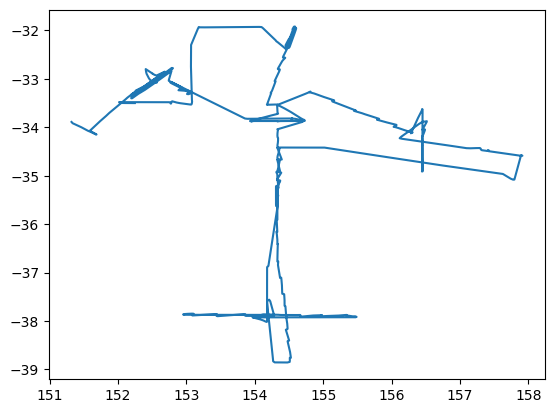

In [3]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

,Time,ID,Lon,Lat,u,v
0,2023-10-17 10:27:31.000004,NaN,154.357059,-37.005208,0.534412,-0.052615
1,2023-10-17 10:42:30.333327,NaN,154.360804,-37.038123,0.533096,-0.055888
2,2023-10-17 10:57:30.666685,NaN,154.364625,-37.071899,0.431565,-0.059157
3,2023-10-17 11:12:30.333340,NaN,154.368274,-37.101418,0.368063,0.005275
4,2023-10-17 11:27:30.666659,NaN,154.372221,-37.104340,0.357789,0.053638
...,...,...,...,...,...,...
1222,2023-12-30 12:00:00.000000,16.0,153.100060,-36.737551,-0.144349,-0.518798
1223,2023-12-30 12:00:00.000000,12.0,152.634326,-36.534064,0.253773,-0.106592
1224,2023-12-30 18:00:00.000000,13.0,152.521350,-36.733268,0.048404,0.129610
1225,2023-12-30 18:00:00.000000,16.0,153.081009,-36.841023,0.003380,-0.582145


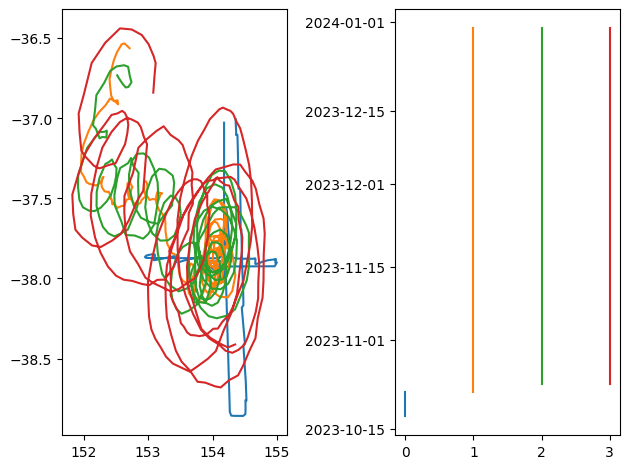

In [6]:
df_obs_data = pd.concat([df_drifters_6hr, df_sadcp], ignore_index=True, sort=False)
# df_obs_data = pd.concat([df_drifters_6hr], ignore_index=True, sort=False)

df_obs_data = df_obs_data.sort_values(by='Time').reset_index(drop=True)

df = df_obs_data.copy()
df.loc[np.isnan(df['ID']), 'ID'] = -1
fig, axs = plt.subplots(1, 2)
for dd, d in enumerate(df['ID'].unique()):
    axs[0].plot(df[df['ID']==d].Lon, df[df['ID']==d].Lat)
    axs[1].plot([dd]*len(df[df['ID']==d]), df[df['ID']==d].Time)

# axs[0].axis('equal')
plt.tight_layout()
df_obs_data

In [7]:
df_obs_data['Time'].min(), df_obs_data['Time'].max()

(Timestamp('2023-10-17 10:27:31.000004'), Timestamp('2023-12-30 18:00:00'))

In [8]:
df_obs_data['Lon'].min(), df_obs_data['Lon'].max()

(np.float64(151.82532501220703), np.float64(154.99832314814816))

In [9]:
df_obs_data['Lat'].min(), df_obs_data['Lat'].max()

(np.float64(-38.857255555555554), np.float64(-36.440286254882814))

In [10]:
df_obs = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'Time'])
dic_obs = {}
start = df_obs_data['Time'].min().round('6h') + pd.Timedelta(days=1)
end = df_obs_data['Time'].max().round('6h') - pd.Timedelta(days=1)

for time in pd.date_range(start=start, end=end, freq='6h'):
    t0 = time - pd.Timedelta(days=1)
    t1 = time + pd.Timedelta(days=1)
    
    df = df_obs_data[(df_obs_data['Time']>=t0)&(df_obs_data['Time']<=t1)]
    xi, yi, ui, vi = df.Lon, df.Lat, df.u, df.v
    xc, yc, w, Q, Rc, psi0 = espra(xi, yi, ui, vi, Rc_max=2)
    df_obs.loc[len(df_obs)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0, 'Time': time}
    dic_obs[time] = df


In [11]:
df_obs

,xc,yc,w,Q,Rc,psi0,Time
0,154.329753,-37.909134,-2.428221,"[[-0.8836251228749252, -0.07099773607155187], ...",0.534698,0.410828,2023-10-18 12:00:00
1,154.304260,-37.964246,-1.889209,"[[-0.5655666562004306, -0.06240271786078613], ...",0.581458,0.520236,2023-10-18 18:00:00
2,154.448043,-37.865204,-1.363198,"[[-0.36848150296027016, 0.07775710218743997], ...",1.163945,1.611789,2023-10-19 00:00:00
3,154.647407,-37.821399,-1.218616,"[[-0.3002327732229834, 0.09637125585188246], [...",1.766570,3.381171,2023-10-19 06:00:00
4,154.614792,-37.969407,-1.218282,"[[-0.30186006362813955, 0.061097881454867754],...",87.706897,-7692.069029,2023-10-19 12:00:00
...,...,...,...,...,...,...,...
285,152.554138,-36.822957,-3.674314,"[[-0.717758687197194, 0.37875334404248867], [0...",1.549181,-2.327207,2023-12-28 18:00:00
286,152.590456,-36.805511,-3.583451,"[[-0.6668889954314272, 0.34325880384618507], [...",1.318463,-1.670289,2023-12-29 00:00:00
287,152.638078,-36.768270,-3.661837,"[[-0.6447848562210798, 0.2804543380795658], [0...",0.648339,-0.366348,2023-12-29 06:00:00
288,152.642346,-36.749623,-3.606317,"[[-0.5831943429695702, 0.2178627881205484], [0...",0.527205,-0.235960,2023-12-29 12:00:00


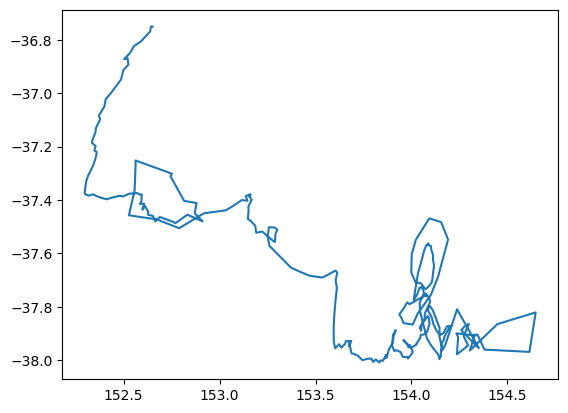

In [12]:
plt.plot(df_obs.xc, df_obs.yc)


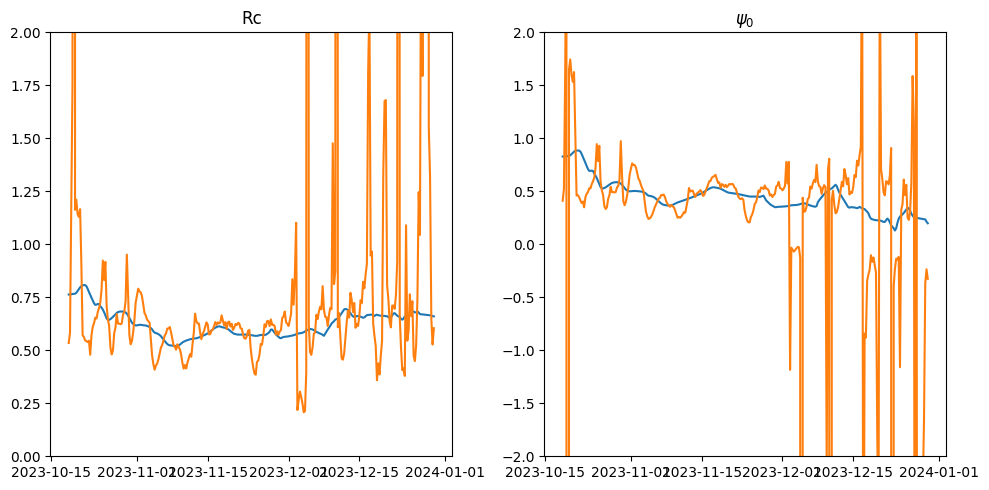

In [13]:
mask = df_obs['Rc'] <= 1.25

df = df_obs[mask]

window = 150
df_obs['sRc'], df_obs['spsi0'] = np.nan, np.nan
df_obs.loc[mask, 'sRc'] = smooth(df['Rc'], np.arange(len(df)), window=window)
df_obs.loc[mask, 'spsi0'] = smooth(df['psi0'], np.arange(len(df)), window=window)

df_obs['sRc'] = df_obs['sRc'].interpolate(method='linear')
df_obs['spsi0'] = df_obs['spsi0'].interpolate(method='linear')
                                   
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(df_obs.Time, df_obs['sRc'])
axs[0].plot(df_obs.Time, df_obs.Rc)
axs[1].plot(df_obs.Time, df_obs['spsi0'])
axs[1].plot(df_obs.Time, df_obs.psi0)
axs[0].set_title('Rc'); axs[1].set_title(r'$\psi_0$')
axs[0].set_ylim(0, 2); axs[1].set_ylim(-2, 2)

plt.tight_layout()


#### IMOS Data

In [14]:
ssh_path = '/srv/scratch/z5297792/IN2023/IMOS_aggregation_20250609T232300Z.nc'
# ssh_path = '/srv/scratch/z5297792/IN2023/IMOS_aggregation.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

tim_ssh = tim_ssh[ tim_ssh <= pd.Timestamp('2024-01-01')]

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}


In [15]:
lon_ssh.min(), lon_ssh.max(), lat_ssh.min(), lat_ssh.max(), tim_ssh.min(), tim_ssh.max()

(np.float64(150.0),
 np.float64(157.0),
 np.float64(-40.0),
 np.float64(-35.0),
 Timestamp('2023-10-16 18:00:00'),
 Timestamp('2024-01-01 00:00:00'))

In [16]:
df_sat = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'Time'])
xc, yc = 154.3, -37.87
for time in tim_ssh:
    ut, vt = dic_ssh_data[time]['u'], dic_ssh_data[time]['v']
    mask = np.hypot(lon_ssh-xc, lat_ssh-yc) <= .5
    xi, yi, ui, vi = lon_ssh[mask], lat_ssh[mask], ut[mask], vt[mask]
    xc, yc, w, Q, Rc, psi0 = espra(xi, yi, ui, vi, Rc_max=2)
    df_sat.loc[len(df_sat)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0, 'Time': time}

mask = df_sat['Rc'] <= 1.25
df = df_sat[mask]
window = 150
df_sat['sRc'], df_sat['spsi0'] = np.nan, np.nan
df_sat.loc[mask, 'sRc'] = smooth(df['Rc'], np.arange(len(df)), window=window)
df_sat.loc[mask, 'spsi0'] = smooth(df['psi0'], np.arange(len(df)), window=window)
df_sat['sRc'] = df_sat['sRc'].interpolate(method='linear')
df_sat['spsi0'] = df_sat['spsi0'].interpolate(method='linear')

df_sat.head()


,xc,yc,w,Q,Rc,psi0,Time,sRc,spsi0
0,154.404478,-37.861376,-2.970975,"[[-0.810032087902945, -0.03408622851998537], [...",0.887884,0.862845,2023-10-16 18:00:00,0.715018,0.581929
1,154.368011,-37.850731,-2.766886,"[[-0.7374682773746747, 0.0012060391505704711],...",0.693263,0.549505,2023-10-17 18:00:00,0.713066,0.578649
2,154.357350,-37.841592,-2.630802,"[[-0.706218809545859, -0.00970614547775683], [...",0.680810,0.531476,2023-10-18 18:00:00,0.715738,0.581748
3,154.348523,-37.836619,-2.627257,"[[-0.7221716515954006, -0.02213878492935811], ...",0.687049,0.534539,2023-10-19 18:00:00,0.717915,0.584031
4,154.353370,-37.840455,-2.797009,"[[-0.7764619930051677, -0.041086610952159514],...",0.691747,0.545087,2023-10-20 18:00:00,0.720557,0.586323


(np.float64(149.65),
 np.float64(157.35),
 np.float64(-40.25),
 np.float64(-34.75))

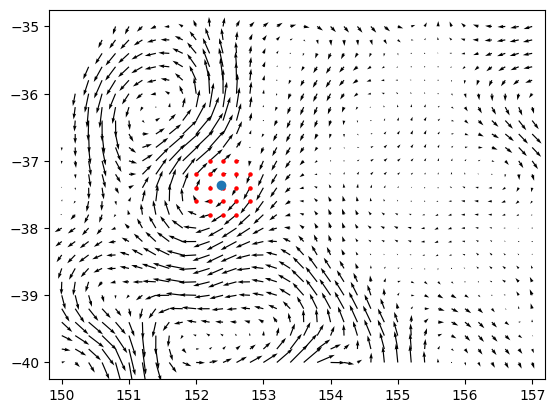

In [17]:
t = 70
time = tim_ssh[t]
ut, vt = dic_ssh_data[time]['u'], dic_ssh_data[time]['v']
plt.quiver(lon_ssh, lat_ssh, ut, vt)
xc, yc = df_sat[df_sat['Time']==time].xc, df_sat[df_sat['Time']==time].yc
time0 = tim_ssh[t-1]
xc0, yc0 = df_sat[df_sat['Time']==time0].iloc[0].xc, df_sat[df_sat['Time']==time0].iloc[0].yc
i, j = np.where(np.hypot(lon_ssh-xc0, lat_ssh-yc0) <= .5)
plt.scatter(lon_ssh[i,j], lat_ssh[i,j], marker='.', s=20, color='r')
plt.scatter(xc, yc)
plt.axis('equal')


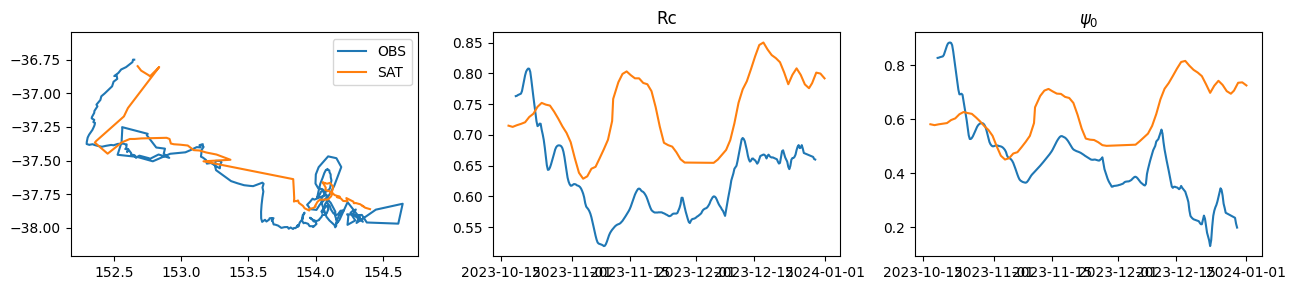

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(13,3))

axs[0].plot(df_obs['xc'], df_obs['yc'], label='OBS')
axs[0].plot(df_sat['xc'], df_sat['yc'], label='SAT')
axs[0].axis('equal')
axs[0].legend()

axs[1].plot(df_obs['Time'], df_obs['sRc'])
axs[2].plot(df_obs['Time'], df_obs['spsi0'])

axs[1].plot(df_sat['Time'], df_sat['sRc'])
axs[2].plot(df_sat['Time'], df_sat['spsi0'])

axs[1].set_title('Rc')
axs[2].set_title(r'$\psi_0$')

plt.tight_layout()


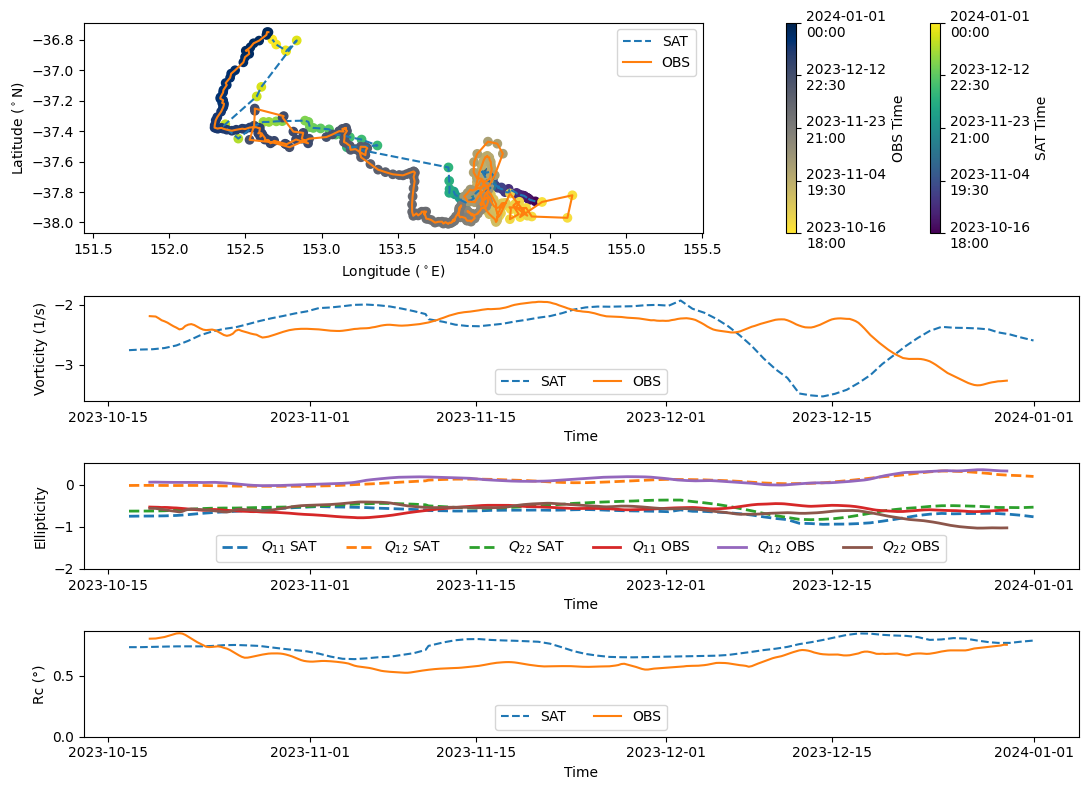

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# compute global min/max timestamps
ts_sat = df_sat['Time'].map(pd.Timestamp.timestamp)
ts_obs = df_obs['Time'].map(pd.Timestamp.timestamp)
vmin, vmax = min(ts_sat.min(), ts_obs.min()), max(ts_sat.max(), ts_obs.max())
norm = Normalize(vmin=vmin, vmax=vmax)

# fig, axs = plt.subplots(4, 1, figsize=(11, 8))

fig, axs = plt.subplots(
    4, 1, figsize=(11, 8),
    gridspec_kw={'height_ratios': [2, 1, 1, 1]}
)

axs[0].plot(df_sat['xc'], df_sat['yc'], label='SAT', linestyle='--')
axs[0].plot(df_obs['xc'], df_obs['yc'], label='OBS')
axs[0].legend()
# SAT scatter
sc_sat = axs[0].scatter(
    df_sat['xc'], df_sat['yc'],
    c=ts_sat, cmap='viridis', norm=norm
)
cbar_sat = fig.colorbar(sc_sat, ax=axs[0], location='right', pad=0.02)
ticks = np.linspace(vmin, vmax, 5)
cbar_sat.set_ticks(ticks)
cbar_sat.set_ticklabels(pd.to_datetime(ticks, unit='s').strftime('%Y-%m-%d\n%H:%M'))
cbar_sat.set_label('SAT Time')
# OBS scatter (same norm!)
sc_obs = axs[0].scatter(
    df_obs['xc'], df_obs['yc'],
    c=ts_obs, cmap='cividis_r', norm=norm
)
cbar_obs = fig.colorbar(sc_obs, ax=axs[0], location='right', pad=0.10)
cbar_obs.set_ticks(ticks)
cbar_obs.set_ticklabels(pd.to_datetime(ticks, unit='s').strftime('%Y-%m-%d\n%H:%M'))
cbar_obs.set_label('OBS Time')
axs[0].axis('equal')

axs[0].set_xlabel(r'Longitude ($^\circ$E)')
axs[0].set_ylabel(r'Latitude ($^\circ$N)')

# axs[1].plot(df_sat['Time'], df_sat['w'])
# axs[1].plot(df_obs['Time'], df_obs['w'])

# Plot 3
wdw = 10
q11 = smooth(df_sat['Q'].apply(lambda Q: Q[0, 0]), df_sat.index, num=len(df_sat), window=wdw)
q12 = smooth(df_sat['Q'].apply(lambda Q: Q[0, 1]), df_sat.index, num=len(df_sat), window=wdw)
q22 = smooth(df_sat['Q'].apply(lambda Q: Q[1, 1]), df_sat.index, num=len(df_sat), window=wdw)
q11_obs = smooth(df_obs['Q'].apply(lambda Q: Q[0, 0]), df_obs.index, num=len(df_obs), window=wdw*4)
q12_obs = smooth(df_obs['Q'].apply(lambda Q: Q[0, 1]), df_obs.index, num=len(df_obs), window=wdw*4)
q22_obs = smooth(df_obs['Q'].apply(lambda Q: Q[1, 1]), df_obs.index, num=len(df_obs), window=wdw*4)

axs[1].plot(df_sat['Time'], 2*(q11+q22), linestyle='--', label='SAT')
axs[1].plot(df_obs['Time'], 2*(q11_obs+q22_obs), label='OBS')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Vorticity (1/s)')
axs[1].legend(loc='lower center', ncol=2)

axs[2].plot(df_sat['Time'], q11, label=r'$Q_{11}$ SAT', linewidth=2, linestyle='--')
axs[2].plot(df_sat['Time'], q12, label=r'$Q_{12}$ SAT', linewidth=2, linestyle='--')
axs[2].plot(df_sat['Time'], q22, label=r'$Q_{22}$ SAT', linewidth=2, linestyle='--')

axs[2].plot(df_obs['Time'], q11_obs, label=r'$Q_{11}$ OBS', linewidth=2)
axs[2].plot(df_obs['Time'], q12_obs, label=r'$Q_{12}$ OBS', linewidth=2)
axs[2].plot(df_obs['Time'], q22_obs, label=r'$Q_{22}$ OBS', linewidth=2)
axs[2].legend(loc='lower center', ncol=6)
axs[2].set_ylim(-2, .5)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Ellipticity')

df1 = df_sat.copy()
df1 = df1[df1['Rc']<= 1.25]
axs[3].plot(df1['Time'], smooth(df1['Rc'], df1.index, num=len(df1), window=wdw), linestyle='--', label='SAT')
df2 = df_obs.copy()
df2 = df2[df2['Rc']<= 1.25]
axs[3].plot(df2['Time'], smooth(df2['Rc'], df2.index, num=len(df2), window=wdw*4), label='OBS')
axs[3].set_ylim(0,None)
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Rc (°)')
axs[3].legend(loc='lower center', ncol=2)

plt.tight_layout()


#### Comparison

In [20]:
df = pd.DataFrame({'xc_sat': df_sat['xc'], 'yc_sat': df_sat['yc'], 
                   'q11_sat': df_sat['Q'].apply(lambda Q: Q[0, 0]),
                   'q12_sat': df_sat['Q'].apply(lambda Q: Q[0, 1]),
                   'q22_sat': df_sat['Q'].apply(lambda Q: Q[1, 1]),
                   'Time': df_sat['Time']})
df = df.set_index('Time').sort_index()

# Create 6-hourly time range within existing bounds
new_time = pd.date_range(
    start=df.index.min().round('6h'),
    end=df.index.max().round('6h'),
    freq='6h'
)
# Reindex and interpolate
df1 = df.reindex(new_time)
df1[['xc_sat', 'yc_sat', 'q11_sat', 'q12_sat', 'q22_sat']] = df1[['xc_sat', 'yc_sat', 'q11_sat', 'q12_sat', 'q22_sat']].interpolate(method='time')
df1


,xc_sat,yc_sat,q11_sat,q12_sat,q22_sat
2023-10-16 18:00:00,154.404478,-37.861376,-0.810032,-0.034086,-0.675455
2023-10-17 00:00:00,154.395361,-37.858715,-0.791891,-0.025263,-0.668085
2023-10-17 06:00:00,154.386245,-37.856054,-0.773750,-0.016440,-0.660715
2023-10-17 12:00:00,154.377128,-37.853392,-0.755609,-0.007617,-0.653345
2023-10-17 18:00:00,154.368011,-37.850731,-0.737468,0.001206,-0.645975
...,...,...,...,...,...
2023-12-31 00:00:00,152.702491,-36.831315,-0.755127,0.088771,-0.527874
2023-12-31 06:00:00,152.696065,-36.823038,-0.754977,0.082133,-0.530897
2023-12-31 12:00:00,152.689638,-36.814762,-0.754827,0.075496,-0.533920
2023-12-31 18:00:00,152.683211,-36.806485,-0.754678,0.068858,-0.536943


In [21]:
df2 = pd.DataFrame({'xc_obs': df_obs['xc'], 'yc_obs': df_obs['yc'], 
                   'q11_obs': df_obs['Q'].apply(lambda Q: Q[0, 0]),
                   'q12_obs': df_obs['Q'].apply(lambda Q: Q[0, 1]),
                   'q22_obs': df_obs['Q'].apply(lambda Q: Q[1, 1]),
                   'Time': df_obs['Time']})
df2 = df2.set_index('Time').sort_index()
df2

,xc_obs,yc_obs,q11_obs,q12_obs,q22_obs
Time,,,,,
2023-10-18 12:00:00,154.329753,-37.909134,-0.883625,-0.070998,-0.330485
2023-10-18 18:00:00,154.304260,-37.964246,-0.565567,-0.062403,-0.379038
2023-10-19 00:00:00,154.448043,-37.865204,-0.368482,0.077757,-0.313117
2023-10-19 06:00:00,154.647407,-37.821399,-0.300233,0.096371,-0.309075
2023-10-19 12:00:00,154.614792,-37.969407,-0.301860,0.061098,-0.307281
...,...,...,...,...,...
2023-12-28 18:00:00,152.554138,-36.822957,-0.717759,0.378753,-1.119398
2023-12-29 00:00:00,152.590456,-36.805511,-0.666889,0.343259,-1.124836
2023-12-29 06:00:00,152.638078,-36.768270,-0.644785,0.280454,-1.186134


In [22]:
df_combined = pd.concat([df1, df2], axis=1, join='inner')
df_combined['ssh_time'] = pd.NaT  # use NaT for datetime-like data

mask = df_combined.index.isin(tim_ssh)
df_combined.loc[mask, 'ssh_time'] = df_combined.index[mask]
df_combined['ssh_time'] = df_combined['ssh_time'].ffill()
df_combined = df_combined.dropna()
df_combined


,xc_sat,yc_sat,q11_sat,q12_sat,q22_sat,xc_obs,yc_obs,q11_obs,q12_obs,q22_obs,ssh_time
2023-10-18 18:00:00,154.357350,-37.841592,-0.706219,-0.009706,-0.609182,154.304260,-37.964246,-0.565567,-0.062403,-0.379038,2023-10-18 18:00:00
2023-10-19 00:00:00,154.355144,-37.840348,-0.710207,-0.012814,-0.604751,154.448043,-37.865204,-0.368482,0.077757,-0.313117,2023-10-18 18:00:00
2023-10-19 06:00:00,154.352937,-37.839105,-0.714195,-0.015922,-0.600320,154.647407,-37.821399,-0.300233,0.096371,-0.309075,2023-10-18 18:00:00
2023-10-19 12:00:00,154.350730,-37.837862,-0.718183,-0.019031,-0.595888,154.614792,-37.969407,-0.301860,0.061098,-0.307281,2023-10-18 18:00:00
2023-10-19 18:00:00,154.348523,-37.836619,-0.722172,-0.022139,-0.591457,154.380524,-37.960748,-0.391299,0.065664,-0.485362,2023-10-19 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 18:00:00,152.790714,-36.851276,-0.798302,0.269565,-0.516011,152.554138,-36.822957,-0.717759,0.378753,-1.119398,2023-12-28 06:00:00
2023-12-29 00:00:00,152.767566,-36.874585,-0.890394,0.218711,-0.548478,152.590456,-36.805511,-0.666889,0.343259,-1.124836,2023-12-29 00:00:00
2023-12-29 06:00:00,152.766851,-36.873301,-0.862216,0.217563,-0.554097,152.638078,-36.768270,-0.644785,0.280454,-1.186134,2023-12-29 00:00:00
2023-12-29 12:00:00,152.766135,-36.872017,-0.834039,0.216415,-0.559717,152.642346,-36.749623,-0.583194,0.217863,-1.219964,2023-12-29 00:00:00


Text(0, 0.5, 'Latitude (°N)')

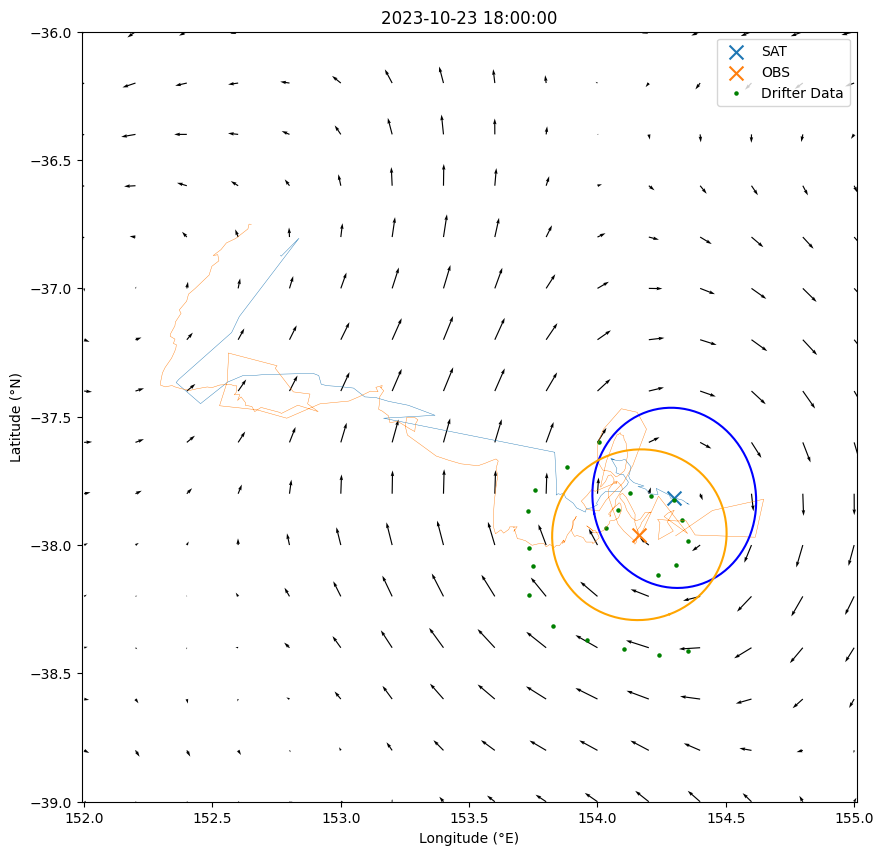

In [23]:
plt.figure(figsize=(10,10))

k = 20
data = df_combined.iloc[k]

t_ssh = data['ssh_time']
time = data.name
ut, vt = dic_ssh_data[t_ssh]['u'], dic_ssh_data[t_ssh]['v']
plt.quiver(lon_ssh, lat_ssh, ut, vt, scale=20, width=.0015)

plt.plot(df_combined.xc_sat, df_combined.yc_sat, linewidth=.3)
plt.plot(df_combined.xc_obs, df_combined.yc_obs, linewidth=.3)

plt.scatter(data.xc_sat, data.yc_sat, s=100, label='SAT', marker='x')
plt.scatter(data.xc_obs, data.yc_obs, s=100, label='OBS', marker='x')

x_ell_sat, y_ell_sat = plot_ellipse(np.array([[data.q11_sat, data.q12_sat], [data.q12_sat, data.q22_sat]]), (data.xc_sat, data.yc_sat), scale=.4)
plt.plot(x_ell_sat, y_ell_sat, 'b')

x_ell_obs, y_ell_obs = plot_ellipse(np.array([[data.q11_obs, data.q12_obs], [data.q12_obs, data.q22_obs]]), (data.xc_obs, data.yc_obs), scale=.4)
plt.plot(x_ell_obs, y_ell_obs, 'orange')

if time in dic_obs.keys():
    df = dic_obs[time]
    mask = np.isnan(df['ID'].values)
    if np.any(mask):
        plt.scatter(df['Lon'][mask], df['Lat'][mask], marker='.', s=20, c='orange', label='SADCP Data')
    if np.any(~mask):
        plt.scatter(df['Lon'][~mask], df['Lat'][~mask], marker='.', s=20, c='g', label='Drifter Data')
plt.title(time)

plt.legend()
plt.axis('equal')
plt.xlim(152, 155)
plt.ylim(-39, -36)

plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')


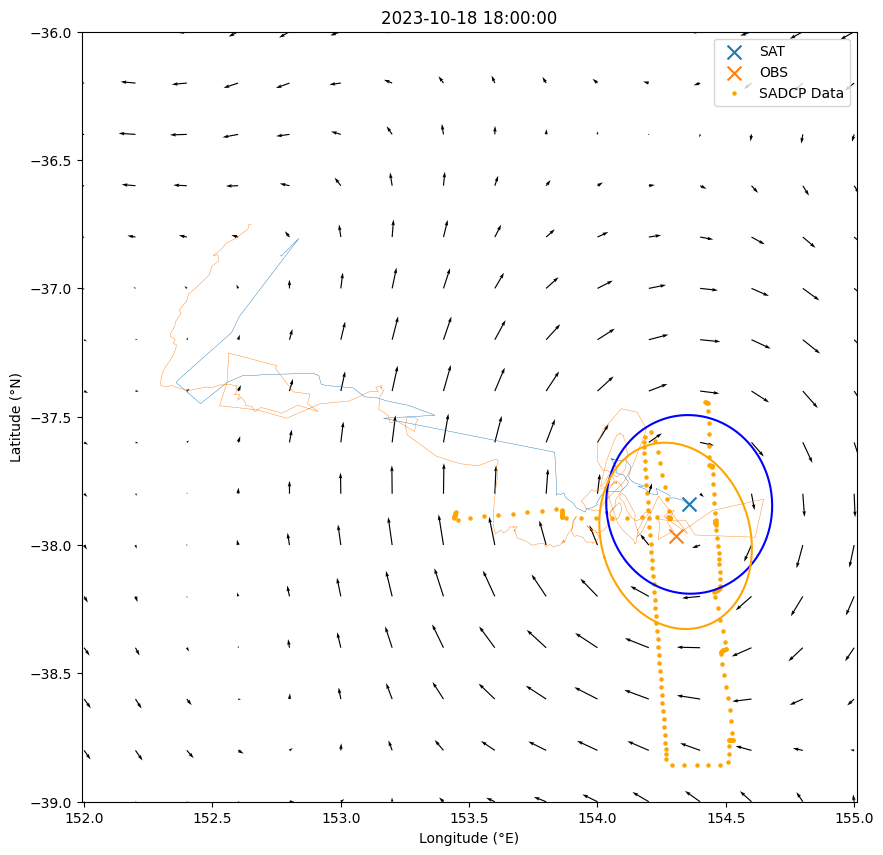

In [24]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10,10))

def update(k):
    ax.clear()
    data = df_combined.iloc[k]
    time = data.name
    t_ssh = data['ssh_time']
    u, v = dic_ssh_data[t_ssh]['u'], dic_ssh_data[t_ssh]['v']
    ax.quiver(lon_ssh, lat_ssh, u, v, scale=20, width=.0015)
    ax.plot(df_combined.xc_sat, df_combined.yc_sat, linewidth=.3)
    ax.plot(df_combined.xc_obs, df_combined.yc_obs, linewidth=.3)
    ax.scatter(data.xc_sat, data.yc_sat, s=100, marker='x', label='SAT')
    ax.scatter(data.xc_obs, data.yc_obs, s=100, marker='x', label='OBS')
    if time in dic_obs.keys():
        df = dic_obs[time]
        mask = df['ID'].isna()
        if np.any(mask):
            ax.scatter(df.loc[mask, 'Lon'], df.loc[mask, 'Lat'], marker='.', s=20, c='orange', label='SADCP Data')
        if np.any(~mask):
            ax.scatter(df.loc[~mask,'Lon'], df.loc[~mask,'Lat'], marker='.', s=20, c='g', label='Drifter Data')
    x_ell_sat, y_ell_sat = plot_ellipse(np.array([[data.q11_sat, data.q12_sat], [data.q12_sat, data.q22_sat]]), (data.xc_sat, data.yc_sat), scale=.4)
    plt.plot(x_ell_sat, y_ell_sat, 'b')
    
    x_ell_obs, y_ell_obs = plot_ellipse(np.array([[data.q11_obs, data.q12_obs], [data.q12_obs, data.q22_obs]]), (data.xc_obs, data.yc_obs), scale=.4)
    plt.plot(x_ell_obs, y_ell_obs, 'orange')
    ax.set_title(str(t_ssh))
    ax.axis('equal')
    ax.set_xlim(152, 155)
    ax.set_ylim(-39, -36)
    ax.set_xlabel('Longitude (°E)')
    ax.set_ylabel('Latitude (°N)')
    if k == 0:
        ax.legend(loc='upper right')

anim = FuncAnimation(fig, update, frames=len(df_combined), interval=200)
anim.save('animation.gif', writer='pillow', dpi=150)
